In [57]:
# import time
# import datetime
# import numpy as np
# import pandas as pd
# from pycoingecko import CoinGeckoAPI

In [58]:
# def timestamp_from_date(date_str):
#     """
#     Converte una stringa 'YYYY-MM-DD' in un timestamp (secondi).
#     """
#     dt = datetime.datetime.strptime(date_str, "%Y-%m-%d")
#     return int(dt.timestamp())

In [59]:
# # Parametri iniziali
# start_date_str = "2020-12-20"    # t = 20 dicembre 2020
# delta_t_days = 180              # es. 180 giorni dopo t
# cg = CoinGeckoAPI()

# # Se desideri testare anche date di fine diverse, puoi calcolarle così:
# start_timestamp = timestamp_from_date(start_date_str)
# end_timestamp = start_timestamp + delta_t_days * 24 * 60 * 60  # secondi totali in delta_t

# # Otteniamo la data di end_date in formato stringa (eventualmente utile per debug/controllo)
# end_date = datetime.datetime.utcfromtimestamp(end_timestamp).strftime('%Y-%m-%d')
# print(f"Period: da {start_date_str} a {end_date} (circa {delta_t_days} giorni)")

# # Passo 2a: Recuperiamo un elenco di crypto (per esempio, top 50 per market cap).
# # L'endpoint get_coins_markets ci dà le monete ordinate per capitalizzazione decrescente
# # Se vuoi più di 50, puoi aumentare per_page, ma occhio ai limiti di API.
# coins_list = cg.get_coins_markets(vs_currency='usd', order='market_cap_desc', per_page=50, page=1)

# # Estraggo solo gli id CoinGecko di queste crypto
# # (es. "bitcoin", "ethereum", "tether", ecc.)
# coin_ids = [coin['id'] for coin in coins_list]

# # Liste dove salvare (market_cap(t), rendimento) per ciascuna crypto
# mcap_list = []
# returns_list = []
# crypto_names = []

In [60]:
# for cid in coin_ids:
#     try:
#         # Scarichiamo i dati storici da CoinGecko
#         # Il metodo get_coin_market_chart_range_by_id ritorna un dict con chiavi: prices, market_caps, total_volumes
#         data_range = cg.get_coin_market_chart_range_by_id(
#             id=cid,
#             vs_currency='usd',  # se non funziona con 'usdt', prova con 'usd'
#             from_timestamp=start_timestamp,
#             to_timestamp=end_timestamp
#         )
        
#         prices = data_range.get('prices', [])
#         market_caps = data_range.get('market_caps', [])

#         # prices e market_caps sono liste di coppie [timestamp, valore]
#         # Esempio: prices[0] = [1608422400000, 23000.0] -> millisecondi, prezzo
#         # Controllo che ci siano dati sufficienti (ad es. almeno 2 rilevazioni)
#         if len(prices) < 2 or len(market_caps) < 2:
#             continue
        
#         # Ricavo p(t) e p(t+delta_t) come primi e ultimi di 'prices'
#         # p(t)
#         p_t = prices[0][1]
#         # p(t+delta_t) (l'ultimo prezzo disponibile vicino al end_timestamp)
#         p_t_plus = prices[-1][1]
        
#         # Market cap a t
#         mcap_t = market_caps[0][1]
        
#         # Rendimento = p(t+delta_t) / p(t)
#         # (in alternativa, se vuoi il “massimo” nel periodo, potresti usare max(prices[i][1]) nel range)
#         ret = p_t_plus / p_t if p_t != 0 else None
        
#         if ret is not None and mcap_t is not None:
#             mcap_list.append(mcap_t)
#             returns_list.append(ret)
#             crypto_names.append(cid)
        
#         # Un delay di 1 secondo tra le chiamate può aiutare a non sovraccaricare le API
#         time.sleep(1)
        
#     except Exception as e:
#         print(f"Errore con {cid}: {e}")
#         continue

In [61]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from scipy.stats import pearsonr, spearmanr

In [62]:
file = pd.read_csv('all_crypto_currencies_with_market_cap.csv')
file

,date,coin_id,cmc_rank,market_cap,price,open,high,low,close,time_high,time_low,volume_24h,percent_change_1h,percent_change_24h,percent_change_7d,circulating_supply,total_supply,max_supply,num_market_pairs
0,2013-04-28,1,1,1.488567e+09,134.210022,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.639231,NaN,NaN,11091325.00,1.109132e+07,2.100000e+07,NaN
1,2013-04-28,2,2,7.463702e+07,4.348405,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.799273,NaN,NaN,17164230.00,1.716423e+07,8.400000e+07,NaN
2,2013-04-28,5,3,7.250187e+06,0.386525,NaN,NaN,NaN,NaN,NaN,NaN,0.0,-0.934763,NaN,NaN,18757362.00,1.875736e+07,NaN,NaN
3,2013-04-28,3,4,5.995997e+06,1.107233,NaN,NaN,NaN,NaN,NaN,NaN,0.0,-0.050503,NaN,NaN,5415300.00,5.415300e+06,NaN,NaN
4,2013-04-28,4,5,1.503099e+06,0.646892,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.609159,NaN,NaN,2323569.75,2.323570e+06,4.200000e+07,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4441967,2021-07-31,11062,5889,0.000000e+00,0.000012,0.000011,0.000012,0.000011,0.000012,23:29:14,00:08:12,0.0,-0.029532,5.182682,0.0,0.00,1.000000e+11,1.000000e+11,2.0
4441968,2021-07-31,11092,5890,0.000000e+00,0.073408,0.074141,0.076020,0.068015,0.073408,00:30:22,09:59:17,0.0,2.720558,-1.000309,0.0,0.00,2.000000e+09,2.000000e+09,1.0
4441969,2021-07-31,11095,5891,0.000000e+00,840.045674,846.683775,848.164610,825.270758,840.045674,00:02:17,14:09:28,0.0,-0.252488,-0.710247,0.0,0.00,0.000000e+00,NaN,1.0
4441970,2021-07-31,11099,5892,0.000000e+00,0.043440,0.041314,0.044082,0.040101,0.043440,21:59:14,05:33:32,0.0,-0.597312,5.359804,0.0,0.00,0.000000e+00,NaN,1.0


In [63]:
file['coin_id'].nunique()

8927

In [64]:
file['date'].min(), file['date'].max()

('2013-04-28', '2021-07-31')

In [65]:
# Filtro i dati temporalmente
file = file[file['date'] >= '2020-12-01']
file

,date,coin_id,cmc_rank,market_cap,price,open,high,low,close,time_high,time_low,volume_24h,percent_change_1h,percent_change_24h,percent_change_7d,circulating_supply,total_supply,max_supply,num_market_pairs
3308739,2020-12-01,1,1,3.496993e+11,18802.998300,19633.770447,19845.975483,18321.920930,18802.998300,11:17:41,13:16:42,4.963366e+10,-0.736995,-4.192620,-1.593441,1.859806e+07,1.859806e+07,2.100000e+07,9754.0
3308740,2020-12-01,1027,2,6.708261e+10,587.324187,615.070325,635.160582,571.753966,587.324187,11:19:13,12:28:13,2.717896e+10,-0.585095,-4.475672,-2.744431,1.142173e+08,1.142173e+08,NaN,5962.0
3308741,2020-12-01,52,3,2.782919e+10,0.612923,0.664515,0.679158,0.594348,0.612923,11:11:03,12:32:03,1.698536e+10,-1.040212,-7.739124,-11.440454,4.540403e+10,9.999083e+10,1.000000e+11,684.0
3308742,2020-12-01,825,4,2.426436e+10,1.001323,1.000369,1.001828,0.999744,1.001323,13:22:08,01:43:08,9.123192e+10,-0.014310,0.094542,0.151529,2.423231e+10,2.478110e+10,NaN,9918.0
3308743,2020-12-01,2,5,5.659745e+09,85.435767,87.576597,92.276780,81.314211,85.435767,14:46:03,13:05:03,9.818291e+09,-1.388934,-2.442335,-4.225762,6.624562e+07,6.624562e+07,8.400000e+07,749.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4441967,2021-07-31,11062,5889,0.000000e+00,0.000012,0.000011,0.000012,0.000011,0.000012,23:29:14,00:08:12,0.000000e+00,-0.029532,5.182682,0.000000,0.000000e+00,1.000000e+11,1.000000e+11,2.0
4441968,2021-07-31,11092,5890,0.000000e+00,0.073408,0.074141,0.076020,0.068015,0.073408,00:30:22,09:59:17,0.000000e+00,2.720558,-1.000309,0.000000,0.000000e+00,2.000000e+09,2.000000e+09,1.0
4441969,2021-07-31,11095,5891,0.000000e+00,840.045674,846.683775,848.164610,825.270758,840.045674,00:02:17,14:09:28,0.000000e+00,-0.252488,-0.710247,0.000000,0.000000e+00,0.000000e+00,NaN,1.0
4441970,2021-07-31,11099,5892,0.000000e+00,0.043440,0.041314,0.044082,0.040101,0.043440,21:59:14,05:33:32,0.000000e+00,-0.597312,5.359804,0.000000,0.000000e+00,0.000000e+00,NaN,1.0


In [66]:
coins = pd.read_csv('coins.csv')
coins.head()

,id,name,slug,symbol,status,category,description,subreddit,notice,tags,...,message_board,chat,explorer,reddit,technical_doc,source_code,announcement,platform_id,date_added,date_launched
0,1,Bitcoin,bitcoin,BTC,active,coin,## **What Is Bitcoin (BTC)?**\n\nBitcoin is a ...,bitcoin,NaN,"mineable, pow, sha-256, store-of-value, state-...",...,https://bitcointalk.org,NaN,https://blockchain.coinmarketcap.com/chain/bit...,https://reddit.com/r/bitcoin,https://bitcoin.org/bitcoin.pdf,https://github.com/bitcoin/,NaN,NaN,2013-04-28T00:00:00.000Z,NaN
1,2,Litecoin,litecoin,LTC,active,coin,## What Is Litecoin (LTC)?\n\nLitecoin (LTC) i...,litecoin,NaN,"mineable, pow, scrypt, medium-of-exchange, bin...",...,"https://litecointalk.io/, https://litecoin-fou...",https://telegram.me/litecoin,"https://blockchair.com/litecoin, https://chain...",https://reddit.com/r/litecoin,NaN,https://github.com/litecoin-project/litecoin,https://bitcointalk.org/index.php?topic=47417.0,NaN,2013-04-28T00:00:00.000Z,NaN
2,3,Namecoin,namecoin,NMC,active,coin,Namecoin (NMC) is a cryptocurrency . Users are...,namecoin,NaN,"mineable, pow, sha-256, platform",...,NaN,https://telegram.me/namecoin,"https://nmc.tokenview.com/, https://www.namebr...",https://reddit.com/r/namecoin,NaN,https://github.com/namecoin,https://bitcointalk.org/?topic=6017.0,NaN,2013-04-28T00:00:00.000Z,NaN
3,4,Terracoin,terracoin,TRC,active,coin,Terracoin (TRC) launched in 2012 with the aim ...,terracoin,NaN,"mineable, pow, sha-256, masternodes",...,https://medium.com/@clockuniverse,"https://mattermost.terracoin.io/, https://t.me...","https://insight.terracoin.io/, https://explore...",https://reddit.com/r/terracoin,https://wiki.terracoin.io/view/Whitepaper,https://github.com/terracoin,https://bitcointalk.org/index.php?topic=1364146.0,NaN,2013-04-28T00:00:00.000Z,NaN
4,5,Peercoin,peercoin,PPC,active,coin,Peercoin (PPC) is a cryptocurrency . Users are...,peercoin,NaN,"mineable, hybrid-pow-pos, sha-256, medium-of-e...",...,https://talk.peercoin.net,"https://t.me/peercoin, https://discord.gg/m294ReV","https://chainz.cryptoid.info/ppc/, https://exp...",https://reddit.com/r/peercoin,https://docs.peercoin.net/,https://github.com/peercoin,https://bitcointalk.org/index.php?topic=101820.0,NaN,2013-04-28T00:00:00.000Z,NaN


In [67]:
def analyze_correlation(file_df, coins_df, start_date_str="2020-12-20", delta_days=180, alpha=0.05, use_min_max=False):
    """
    Esegue l'analisi di correlazione tra market cap(t) e rendimento.
    Metodo: rendimento p(t+delta)/p(t) o max/min prezzo.
    file_df: DataFrame con colonne [coin_id, date, close, market_cap].
    coins_df: DataFrame con colonne [id, symbol] (non usata qui, ma potresti usarla per stampe).
    start_date_str: data di inizio (stringa YYYY-MM-DD).
    delta_days: quanti giorni dopo start_date considerare.
    alpha: livello di significatività (default 0.05).
    use_min_max: se True, usa max/min prezzo, altrimenti p(t+delta)/p(t).
    """

    print("=== Inizio analisi di correlazione ===")
    print(f"Data di inizio (t): {start_date_str}")
    print(f"Delta t (gg): {delta_days}")
    print(f"Livello di significatività alpha: {alpha}")
    print(f"Metodo calcolo rendimento: {'max/min' if use_min_max else 'p(t+delta)/p(t)'}")
    
    # Converto la colonna date in datetime
    if file_df["date"].dtype == object:
        print("Converto la colonna 'date' in datetime...")
        file_df["date"] = pd.to_datetime(file_df["date"], format="%Y-%m-%d", errors="coerce")
    
    start_date = datetime.strptime(start_date_str, "%Y-%m-%d")
    end_date = start_date + timedelta(days=delta_days)
    print(f"Data di fine (t + delta_t): {end_date.strftime('%Y-%m-%d')}")

    max_available_date = file_df["date"].max()
    print(f"Data massima disponibile nel dataset: {max_available_date.strftime('%Y-%m-%d')}")

    # Lista con i risultati
    results = []
    
    # Unici coin_id presenti
    unique_coins = file_df["coin_id"].unique()
    print(f"Numero di coin_id unici trovati nel dataset: {len(unique_coins)}")

    # Crea un dizionario: {id: symbol, ...}
    id_to_symbol = dict(zip(coins_df["id"], coins_df["symbol"]))

    # Itero su ciascun coin_id
    for cid in unique_coins:
        symbol = id_to_symbol.get(cid, "Unknown")
        print(f"\n--- Inizio analisi coin_id: {cid} (symbol: {symbol}) ---")
        
        df_coin = file_df[file_df["coin_id"] == cid].copy()

        # Filtro nel range [start_date, end_date]
        df_coin_in_range = df_coin[
            (df_coin["date"] >= start_date) & (df_coin["date"] <= end_date)
        ]

        # Se non ho dati in questo range, salto la coin
        if df_coin_in_range.empty:
            print(f" -> Nessun dato per {cid} nel periodo {start_date} - {end_date}, skip.")
            continue
        
        # Ordino per data (cronologicamente)
        df_coin_in_range.sort_values(by="date", inplace=True)

        # p(t) e market cap(t) = prima riga
        first_row = df_coin_in_range.iloc[0]
        mcap_t = first_row["market_cap"]

        if use_min_max:
            # Metodo max/min prezzo
            price_max = df_coin_in_range["close"].max()
            price_min = df_coin_in_range["close"].min()

            # Check per NaN
            if pd.isna(price_max) or pd.isna(price_min) or pd.isna(mcap_t):
                print(f" -> Dati NaN per {cid} (price_max={price_max}, price_min={price_min}, mcap_t={mcap_t}). Skip.")
                continue
            
            # Evita divisione per zero
            if price_min == 0:
                print(f" -> Il minimo prezzo è 0 per {cid}, impossibile calcolare il rendimento. Skip.")
                continue

            ret = price_max / price_min
            print(f" -> price_max = {price_max}, price_min = {price_min}, mcap(t) = {mcap_t}, return = {ret}")

        else:
            # Metodo p(t+delta)/p(t)
            last_row = df_coin_in_range.iloc[-1]
            p_t = first_row["close"]
            p_t_plus = last_row["close"]

            # Check per NaN
            if pd.isna(p_t) or pd.isna(p_t_plus) or pd.isna(mcap_t):
                print(f" -> Dati NaN per {cid} (p_t={p_t}, p_t_plus={p_t_plus}, mcap_t={mcap_t}). Skip.")
                continue
            
            # Evita divisione per zero
            if p_t == 0:
                print(f" -> p(t) = 0 per {cid}, impossibile calcolare il rendimento. Skip.")
                continue
            
            ret = p_t_plus / p_t
            print(f" -> p(t) = {p_t}, p(t+delta) = {p_t_plus}, mcap(t) = {mcap_t}, return = {ret}")

        # Aggiungi il risultato alla lista
        results.append({
            "coin_id": cid,
            "symbol": symbol,
            "mcap_t": mcap_t,
            "return": ret
        })
    
    # Creo un dataframe con i risultati
    df_corr = pd.DataFrame(results)
    print("\n=== Risultati finali raccolti ===")
    if df_corr.empty:
        print("Nessuna coin è stata valida (dopo filtri e NaN). Impossibile calcolare la correlazione.")
        return None
    
    # Filtro le crypto con mcap_t diversa da 0
    df_corr = df_corr[df_corr["mcap_t"] != 0]
    if df_corr.empty:
        print("Tutte le crypto valide hanno market cap iniziale pari a 0. Impossibile calcolare la correlazione.")
        return None

    print(f"Numero di crypto con market cap iniziale diversa da 0: {len(df_corr)}")
    
    display(df_corr)

    # Calcolo correlazione Pearson
    corr_value, p_value = pearsonr(df_corr["mcap_t"], df_corr["return"])

    # Correlazione Spearman (facoltativa, ma spesso utile)
    spearman_corr, spearman_p = spearmanr(df_corr["mcap_t"], df_corr["return"])

    print("\n--- CORRELAZIONI ---")
    print(f"Pearson R = {corr_value} (p-value = {p_value})")
    print(f"Spearman ρ = {spearman_corr} (p-value = {spearman_p})")

    # Ritorno l'oggetto df_corr e i valori di correlazione, se vuoi usarli dopo
    return {
        "df_corr": df_corr,
        "pearson_r": corr_value,
        "pearson_p": p_value,
        "spearman_r": spearman_corr,
        "spearman_p": spearman_p
    }

In [68]:
results = analyze_correlation(file, coins, "2020-12-20", 180, 0.05, True)
results

=== Inizio analisi di correlazione ===
Data di inizio (t): 2020-12-20
Delta t (gg): 180
Livello di significatività alpha: 0.05
Metodo calcolo rendimento: max/min
Converto la colonna 'date' in datetime...
Data di fine (t + delta_t): 2021-06-18
Data massima disponibile nel dataset: 2021-07-31
Numero di coin_id unici trovati nel dataset: 6658

--- Inizio analisi coin_id: 1 (symbol: BTC) ---
 -> price_max = 63503.45793019, price_min = 22803.0814087, mcap(t) = 436129331482.256, return = 2.7848630100474794

--- Inizio analisi coin_id: 1027 (symbol: ETH) ---
 -> price_max = 4168.70104865, price_min = 583.71459689, mcap(t) = 72711065644.9765, return = 7.1416768928867205

--- Inizio analisi coin_id: 52 (symbol: XRP) ---
 -> price_max = 1.83923574, price_min = 0.2118282, mcap(t) = 25247252304.5062, return = 8.68267652748784

--- Inizio analisi coin_id: 825 (symbol: USDT) ---


C:\Users\Alessandro\AppData\Local\Temp\ipykernel_11096\93018872.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  file_df["date"] = pd.to_datetime(file_df["date"], format="%Y-%m-%d", errors="coerce")
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_11096\93018872.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_coin_in_range.sort_values(by="date", inplace=True)


 -> price_max = 1.01152966, price_min = 0.99848059, mcap(t) = 20293091729.7127, return = 1.013068927058462

--- Inizio analisi coin_id: 2 (symbol: LTC) ---
 -> price_max = 386.45077919, price_min = 101.81706223, mcap(t) = 7583089812.36372, return = 3.795540459780952

--- Inizio analisi coin_id: 1975 (symbol: LINK) ---
 -> price_max = 52.19869656, price_min = 10.8313119, mcap(t) = 5195479300.21972, return = 4.819240461536336

--- Inizio analisi coin_id: 1831 (symbol: BCH) ---
 -> price_max = 1542.4250417, price_min = 274.14842097, mcap(t) = 6476086511.26121, return = 5.626240837873683

--- Inizio analisi coin_id: 2010 (symbol: ADA) ---
 -> price_max = 2.30911258, price_min = 0.13639415, mcap(t) = 5039863586.81498, return = 16.929703949912806

--- Inizio analisi coin_id: 3408 (symbol: USDC) ---
 -> price_max = 1.01049621, price_min = 0.99791185, mcap(t) = 3356572079.29183, return = 1.0126106930186267

--- Inizio analisi coin_id: 6636 (symbol: DOT) ---
 -> price_max = 47.94594002, price_m

,coin_id,symbol,mcap_t,return
0,1,BTC,4.361293e+11,2.784863
1,1027,ETH,7.271107e+10,7.141677
2,52,XRP,2.524725e+10,8.682677
3,825,USDT,2.029309e+10,1.013069
4,2,LTC,7.583090e+09,3.795540
...,...,...,...,...
5436,10049,CITY,6.120032e+07,2.266075
5451,1405,PEPECASH,6.071619e+06,7.692215
5531,10121,BNU,1.185735e+06,1.919222
5543,32,FST,1.858361e+07,53.106022



--- CORRELAZIONI ---
Pearson R = -0.000868109325984296 (p-value = 0.9660033076865463)
Spearman ρ = -0.16840091727654732 (p-value = 8.257367438940875e-17)


{'df_corr':       coin_id    symbol        mcap_t     return
 0           1       BTC  4.361293e+11   2.784863
 1        1027       ETH  7.271107e+10   7.141677
 2          52       XRP  2.524725e+10   8.682677
 3         825      USDT  2.029309e+10   1.013069
 4           2       LTC  7.583090e+09   3.795540
 ...       ...       ...           ...        ...
 5436    10049      CITY  6.120032e+07   2.266075
 5451     1405  PEPECASH  6.071619e+06   7.692215
 5531    10121       BNU  1.185735e+06   1.919222
 5543       32       FST  1.858361e+07  53.106022
 5596    10188       ATA  2.605418e+08   2.506140
 
 [2413 rows x 4 columns],
 'pearson_r': -0.000868109325984296,
 'pearson_p': 0.9660033076865463,
 'spearman_r': -0.16840091727654732,
 'spearman_p': 8.257367438940875e-17}

In [69]:
results['df_corr']

,coin_id,symbol,mcap_t,return
0,1,BTC,4.361293e+11,2.784863
1,1027,ETH,7.271107e+10,7.141677
2,52,XRP,2.524725e+10,8.682677
3,825,USDT,2.029309e+10,1.013069
4,2,LTC,7.583090e+09,3.795540
...,...,...,...,...
5436,10049,CITY,6.120032e+07,2.266075
5451,1405,PEPECASH,6.071619e+06,7.692215
5531,10121,BNU,1.185735e+06,1.919222
5543,32,FST,1.858361e+07,53.106022


In [76]:
results['df_corr'].sort_values(by='return')

,coin_id,symbol,mcap_t,return
2147,1763,BRIA,7.434308e+03,1.000000e+00
3642,2922,ATMI,4.929771e+04,1.000000e+00
1234,4186,BGBP,9.729054e+05,1.002399e+00
1921,3402,IFOOD,5.248116e+04,1.004292e+00
803,4360,FAB,4.893873e+06,1.004433e+00
...,...,...,...,...
2171,3180,COMP,1.082801e+04,8.270100e+04
2015,3006,NBR,2.020242e+04,1.982144e+05
496,6005,CVA,6.763374e+06,2.708921e+06
1997,3013,PRIV,3.011151e+04,2.906167e+06


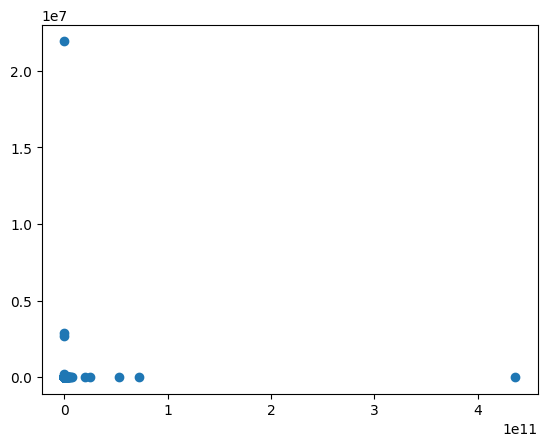

In [70]:
import matplotlib.pyplot as plt
plt.scatter(results['df_corr']['mcap_t'], results['df_corr']['return'])

### Ricerca relazione del tipo f(mcap_t, return) = k = costante usando random forest

In [71]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score
import matplotlib.pyplot as plt
import pandas as pd

def find_relationship_mcap_return(df_corr, max_depth=5, n_estimators=100):
    """
    Verifica se esiste una funzione f(mcap_t, return) = k con buona approssimazione.
    
    Parameters:
        df_corr (pd.DataFrame): DataFrame con colonne 'mcap_t' e 'return'.
        max_depth (int): Profondità massima del modello Random Forest.
        n_estimators (int): Numero di alberi nel modello Random Forest.
    
    Returns:
        dict: Contiene i risultati di addestramento, test, e validazione.
    """
    # Estraggo le colonne interessate
    X = df_corr[['mcap_t', 'return']].values
    y = np.ones(len(X))  # La relazione desiderata è f(X) ≈ costante
    
    # Normalizzazione
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Suddividi in train/test
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

    # Modello: Random Forest
    model = RandomForestRegressor(max_depth=max_depth, n_estimators=n_estimators, random_state=42)
    model.fit(X_train, y_train)

    # Predizioni su train e test
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Calcolo MSE per train e test
    mse_train = mean_squared_error(y_train, y_train_pred)
    mse_test = mean_squared_error(y_test, y_test_pred)
    
    print(f"MSE Train: {mse_train:.6f}")
    print(f"MSE Test: {mse_test:.6f}")
    
    # Cross-validation
    cv_scores = cross_val_score(model, X_scaled, y, cv=5, scoring='neg_mean_squared_error')
    cv_mse = -cv_scores.mean()
    print(f"Cross-Validation MSE: {cv_mse:.6f}")
    
    # Valutazione dell'importanza delle feature
    feature_importances = model.feature_importances_
    print(f"Importanza di 'mcap_t': {feature_importances[0]:.4f}")
    print(f"Importanza di 'return': {feature_importances[1]:.4f}")
    
    # Visualizzazione (test set)
    plt.figure(figsize=(10, 6))
    plt.scatter(df_corr['mcap_t'], df_corr['return'], c=model.predict(X_scaled), cmap='viridis', alpha=0.8)
    plt.colorbar(label='Valore predetto (f(mcap_t, return))')
    plt.xlabel('Market Cap (mcap_t)')
    plt.ylabel('Return')
    plt.title('Visualizzazione della funzione approssimata f(mcap_t, return)')
    plt.show()
    
    return {
        'predicted_k_mean': np.mean(model.predict(X_scaled)),  # Valore medio predetto di f(mcap_t, return)
        'mse_train': mse_train,  # MSE sul train set
        'mse_test': mse_test,  # MSE sul test set
        'cv_mse': cv_mse,  # MSE medio in cross-validation
        'feature_importances': feature_importances.tolist(),  # Importanza delle feature
    }

MSE Train: 0.000000
MSE Test: 0.000000
Cross-Validation MSE: -0.000000
Importanza di 'mcap_t': 0.0000
Importanza di 'return': 0.0000


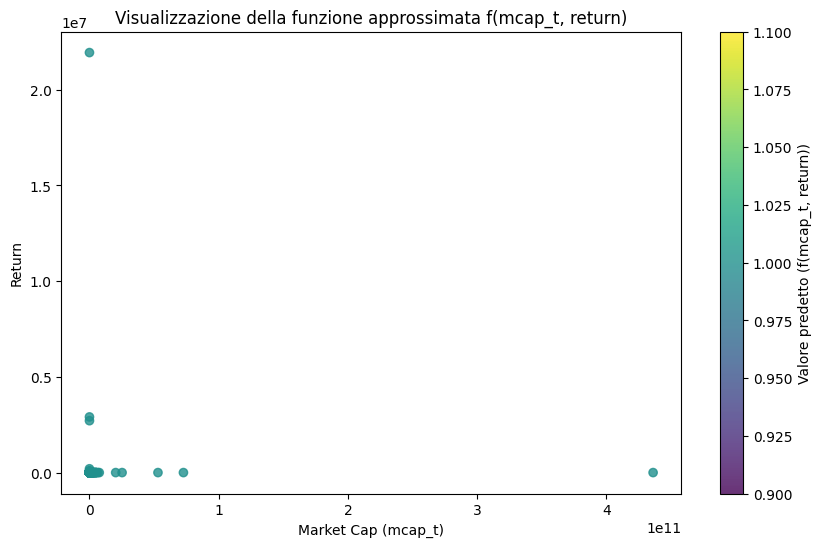

{'predicted_k_mean': 1.0,
 'mse_train': 0.0,
 'mse_test': 0.0,
 'cv_mse': -0.0,
 'feature_importances': [0.0, 0.0]}

In [72]:
# # Esempio di utilizzo
# results = {
#     'df_corr': {
#         'mcap_t': np.random.uniform(1e6, 1e8, 100),
#         'return': np.random.uniform(0.8, 1.2, 100)
#     }
# }

df_corr = pd.DataFrame(results['df_corr'])
output = find_relationship_mcap_return(df_corr)
output

In [73]:
# Conclusione: pare non ci sia alcuna relazione tra market cap e massimo rendimento ottenuto dal prezzo nel periodo considerato